
**Install requirements**

In [1]:
!pip3 install 'torch==1.3.1'
!pip3 install 'torchvision==0.4.2'
!pip3 install 'Pillow-SIMD'
!pip3 install 'tqdm'

**Import libraries**

In [0]:
import os
import logging

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn

import torchvision
from torchvision import transforms
from torchvision.models import alexnet

from PIL import Image
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt

**Set Arguments**

In [0]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 101 # UPDATED, 101 + 1: There is am extra Background class that should be removed 

BATCH_SIZE = 256     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 0.01           # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 30 #was 30     # Total number of training epochs (iterations over dataset)
STEP_SIZE = 20 #was 20      # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.8          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 10

**Define Data Preprocessing**

In [0]:
# Define transforms for training phase
train_transform = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.CenterCrop(224),  # Crops a central square patch of the image
                                                                   # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                   # Remember this when applying different transformations, otherwise you get an error
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) # Normalizes tensor with mean and standard deviation
])
# Define transforms for the evaluation phase
eval_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))                                    
])

#Point4 Data Augmentation
train_aug_transform_1 = transforms.Compose([transforms.Resize(256),
                                          transforms.ColorJitter(brightness=20, contrast=10, saturation=30),
                                          transforms.CenterCrop(224),
                                          transforms.ToTensor(),
                                          transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])
train_aug_transform_2 = transforms.Compose([transforms.Resize(256),
                                          transforms.ColorJitter(contrast=10, hue=0.2),
                                          transforms.RandomHorizontalFlip(p=0.5),
                                          transforms.CenterCrop(224),
                                          transforms.ToTensor(),
                                          transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

train_aug_transform_3 = transforms.Compose([transforms.Resize(256),
                                          transforms.RandomRotation(degrees=15),
                                          transforms.CenterCrop(224),
                                          transforms.ToTensor(),
                                          transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

**Prepare Dataset**

## Filter out Background class

In [0]:
from torchvision.datasets import VisionDataset

from PIL import Image
from IPython.core.debugger import set_trace

import re
import os
import os.path
import sys

IMG_EXTENSIONS = ('.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp')

def has_file_allowed_extension(filename, extensions):
    """Checks if a file is an allowed extension.

    Args:
        filename (string): path to a file
        extensions (tuple of strings): extensions to consider (lowercase)

    Returns:
        bool: True if the filename ends with one of given extensions
    """
    return filename.lower().endswith(extensions)


def is_image_file(filename):
    """Checks if a file is an allowed image extension.

    Args:
        filename (string): path to a file

    Returns:
        bool: True if the filename ends with a known image extension
    """
    return has_file_allowed_extension(filename, IMG_EXTENSIONS)


def make_dataset(dir, class_to_idx, extensions=None, is_valid_file=None, split=None):
    #set_trace()
    dir = os.path.expanduser(dir)
    home = dir.split('/') # home = Homework2-Caltech101
    images = []
    #set_trace()

    if not ((extensions is None) ^ (is_valid_file is None)):
        raise ValueError("Both extensions and is_valid_file cannot be None or not None at the same time")
    if extensions is not None:
        def is_valid_file(x):
            return has_file_allowed_extension(x, extensions)

    if split == 'train':
        train_images_paths = [line.rstrip('\n') for line in open(home[0]+'/train.txt')  if 'BACKGROUND_Google/' not in line]  
      
        for tip in train_images_paths:
          path = os.path.join(dir, tip)
          if is_valid_file(path):
            #set_trace()
            target = tip.split('/')[0]
            item = (path, class_to_idx[target])
            images.append(item)

    elif split == 'test':
        test_images_paths = [line.rstrip('\n') for line in open(home[0]+'/test.txt') if 'BACKGROUND_Google/' not in line]

        for tip in test_images_paths:     
          path = os.path.join(dir, tip)
          if is_valid_file(path):
            #set_trace()
            target = tip.split('/')[0]

            item = (path, class_to_idx[target])
            images.append(item)

    else: 
        RuntimeError("This function create dataset folder based on a split: <train or test>")

    return images



def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')


def accimage_loader(path):
    import accimage
    try:
        return accimage.Image(path)
    except IOError:
        # Potentially a decoding problem, fall back to PIL.Image
        return pil_loader(path)


def default_loader(path):
    #set_trace()
    from torchvision import get_image_backend
    if get_image_backend() == 'accimage':
        return accimage_loader(path)
    else:
        return pil_loader(path)

class Caltech(VisionDataset):

    def __init__(self, root, loader, extensions=None, transform=None,
                 target_transform=None, is_valid_file=None, split=None):
        super(Caltech, self).__init__(root, transform=transform,
                                            target_transform=target_transform)
        
        self.split = split
        self.loader = pil_loader
        self.extensions = extensions
        classes, class_to_idx = self._find_classes(self.root)
        samples = make_dataset(self.root, class_to_idx, IMG_EXTENSIONS, is_valid_file, self.split)
        #set_trace()
        if len(samples) == 0:
            raise (RuntimeError("Found 0 files in subfolders of: " + self.root + "\n"
                                "Supported extensions are: " + ",".join(extensions)))


        self.classes = classes
        self.class_to_idx = class_to_idx
        self.samples = samples
        self.targets = [s[1] for s in samples]
        print('\n[{}] Number of classes: {}'.format(self.split, len(classes)))

    def _find_classes(self, dir):
        classes = []
        #set_trace()
        home = dir.split('/')[0]
        train_images_paths = [line.rstrip('\n') for line in open(home+'/train.txt')  if 'BACKGROUND_Google/' not in line]  

        for tip in train_images_paths:
          #set_trace()
          label = tip.split('/')[0]
          if label not in classes:
            classes.append(label)
        
        

        #classes = [d.name for d in os.scandir(dir) if (d.is_dir() and (re.match(r'[^BACKGROUND_Google+]', d.name)))]
        #set_trace()
        classes = sorted(classes, key = lambda s: s.casefold())
        #classes.sort()
        class_to_idx = {classes[i]: i for i in range(len(classes))}

        return classes, class_to_idx

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (sample, target) where target is class_index of the target class.
        """
        #set_trace()
        path, target = self.samples[index]
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)

        return sample, target


    def __len__(self):
        
        return len(self.samples)



IMG_EXTENSIONS = ('.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp')




class CaltechImageFolder(Caltech):


    def __init__(self, root, transform=None, target_transform=None,
                 loader=default_loader, is_valid_file=None):
        #set_trace()
        super(CaltechImageFolder, self).__init__(root, loader, IMG_EXTENSIONS if is_valid_file is None else None,
                                          transform=transform,
                                          target_transform=target_transform,
                                          is_valid_file=is_valid_file)
        
        self.imgs = self.samples

In [6]:
# Clone github repository with data
if not os.path.isdir('./Homework2-Caltech101'):
  !git clone https://github.com/MachineLearning2020/Homework2-Caltech101.git

DATA_DIR = 'Homework2-Caltech101/101_ObjectCategories'
train_split_paths = 'Homework2-Caltech101/train.txt'
test_split_paths = 'Homework2-Caltech101/test.txt'


# Prepare Pytorch train/test Datasets
train_dataset = Caltech(DATA_DIR, IMG_EXTENSIONS, split='train', transform=train_aug_transform_3)
test_dataset = Caltech(DATA_DIR, IMG_EXTENSIONS, split='test', transform=eval_transform)



#train_ds_imageFolder = CaltechImageFolder(train_dataset_folder)
#test_ds_imageFolder = CaltechImageFolder(test_dataset_folder)

#train_dataset = torchvision.datasets.ImageFolder(DATA_DIR, transform=train_transform)
#test_dataset = torchvision.datasets.ImageFolder(DATA_DIR, transform=eval_transform)


#train_indexes = [idx for idx in range(len(train_dataset)) if idx % 5]
#test_indexes = [idx for idx in range(len(test_dataset)) if not idx % 5]



# Check dataset sizes
print('Train Dataset Size: {}'.format(len(train_dataset)))
print('Test Dataset Size: {}'.format(len(test_dataset)))




[train] Number of classes: 101

[test] Number of classes: 101
Train Dataset Size: 5784
Test Dataset Size: 2893


**Validation Set for hyperparameter tuning and model selection**

In [7]:
from torch.utils.data.sampler import SubsetRandomSampler

val_split = .5
shuffle_dataset = True
random_seed = 20
#Creating data indexes for training and validation splits:

training_big_size = len(train_dataset)
print('Initial size of training set: {}\n'.format(training_big_size))
indexes = list(range(training_big_size))
split = int(np.floor(val_split * training_big_size))


if shuffle_dataset:
  np.random.seed(random_seed)
  np.random.shuffle(indexes)
train_idx, val_idx = indexes[split:], indexes[:split]
#set_trace()

train_dataset_new = Subset(train_dataset, train_idx)
val_dataset_new = Subset(train_dataset, val_idx)
print('Index for new training and validation set created:\nTraining: {}\nValidation: {}'.format(sorted(train_idx), sorted(val_idx)))
print('New sizes:\ntrain_new: {}\nval_new: {}'.format(len(train_dataset_new), len(val_dataset_new)))

Initial size of training set: 5784

Index for new training and validation set created:
Training: [1, 2, 3, 4, 6, 7, 8, 9, 10, 15, 16, 19, 22, 26, 28, 30, 31, 34, 35, 37, 39, 40, 43, 46, 47, 48, 50, 51, 54, 59, 63, 70, 72, 73, 76, 77, 79, 81, 83, 85, 86, 88, 91, 93, 94, 95, 96, 98, 99, 102, 103, 108, 112, 114, 116, 119, 121, 123, 124, 126, 128, 132, 134, 135, 137, 138, 144, 146, 147, 149, 151, 153, 154, 158, 159, 160, 161, 162, 164, 165, 167, 169, 170, 172, 173, 175, 177, 182, 183, 186, 188, 192, 194, 196, 197, 199, 201, 204, 205, 208, 210, 211, 212, 214, 217, 218, 221, 225, 228, 230, 233, 234, 235, 236, 237, 239, 241, 243, 244, 248, 251, 252, 258, 259, 262, 263, 264, 267, 271, 273, 278, 280, 281, 282, 285, 286, 289, 290, 293, 295, 296, 298, 299, 300, 301, 302, 304, 306, 308, 314, 315, 316, 319, 324, 325, 329, 330, 331, 336, 340, 341, 343, 346, 347, 348, 352, 356, 358, 359, 360, 361, 362, 364, 368, 369, 370, 372, 373, 374, 377, 378, 379, 380, 382, 384, 385, 386, 388, 393, 397, 399, 401,

**Prepare Dataloaders**

In [0]:
# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
train_dataloader = DataLoader(train_dataset_new, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
val_dataloader = DataLoader(val_dataset_new, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

**Prepare Network**

In [0]:
net = alexnet(pretrained=True) # Loading AlexNet model

# AlexNet has 1000 output neurons, corresponding to the 1000 ImageNet's classes
# We need 101 outputs for Caltech-101
net.classifier[6] = nn.Linear(4096, NUM_CLASSES) # nn.Linear in pytorch is a fully connected layer
                                                 # The convolutional layer is nn.Conv2d

# We just changed the last layer of AlexNet with a new fully connected layer with 101 outputs
# It is mandatory to study torchvision.models.alexnet source code

**Prepare Training**

In [0]:
# Define loss function
criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy

# Choose parameters to optimize
# To access a different set of parameters, you have to access submodules of AlexNet
# (nn.Module objects, like AlexNet, implement the Composite Pattern)
# e.g.: parameters of the fully connected layers: net.classifier.parameters()
# e.g.: parameters of the convolutional layers: look at alexnet's source code ;) 
parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet
train_conv = net.features.parameters()
train_fully_conn = net.classifier.parameters()

# Define optimizer
# An optimizer updates the weights based on loss
# We use SGD with momentum
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

# Define scheduler
# A scheduler dynamically changes learning rate
# The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

**Train**

Starting epoch 1/30, LR = [0.01]
Step 0, Loss 4.941923141479492


  0%|          | 0/11 [00:00<?, ?it/s]

Step 10, Loss 2.059501886367798


100%|██████████| 11/11 [00:08<00:00,  1.51it/s]


Validation Accuracy: 0.5463347164591977
Starting epoch 2/30, LR = [0.01]


Step 20, Loss 0.9335706830024719


100%|██████████| 11/11 [00:08<00:00,  1.58it/s]


Validation Accuracy: 0.7022821576763485
Starting epoch 3/30, LR = [0.01]


Step 30, Loss 0.5316902995109558


100%|██████████| 11/11 [00:08<00:00,  1.53it/s]


Validation Accuracy: 0.7579529737206085
Starting epoch 4/30, LR = [0.01]


Step 40, Loss 0.23374278843402863


100%|██████████| 11/11 [00:08<00:00,  1.93it/s]


Validation Accuracy: 0.7531120331950207
Starting epoch 5/30, LR = [0.01]


Step 50, Loss 0.20316849648952484


100%|██████████| 11/11 [00:08<00:00,  1.50it/s]


Validation Accuracy: 0.7700553250345782
Starting epoch 6/30, LR = [0.01]


Step 60, Loss 0.14595992863178253


100%|██████████| 11/11 [00:08<00:00,  1.55it/s]


Validation Accuracy: 0.7672890733056709
Starting epoch 7/30, LR = [0.01]


Step 70, Loss 0.10845653712749481


100%|██████████| 11/11 [00:08<00:00,  1.29it/s]


Validation Accuracy: 0.7724757952973721
Starting epoch 8/30, LR = [0.01]


Step 80, Loss 0.09124748408794403


100%|██████████| 11/11 [00:08<00:00,  1.47it/s]


Validation Accuracy: 0.7738589211618258
Starting epoch 9/30, LR = [0.01]


Step 90, Loss 0.04744446277618408


100%|██████████| 11/11 [00:08<00:00,  1.54it/s]


Validation Accuracy: 0.7776625172890733
Starting epoch 10/30, LR = [0.01]


Step 100, Loss 0.028942380100488663


100%|██████████| 11/11 [00:08<00:00,  1.50it/s]


Validation Accuracy: 0.789073305670816
Starting epoch 11/30, LR = [0.01]


Step 110, Loss 0.021508019417524338


  0%|          | 0/11 [00:00<?, ?it/s]

Step 120, Loss 0.05061619356274605


100%|██████████| 11/11 [00:08<00:00,  1.47it/s]


Validation Accuracy: 0.7866528354080221
Starting epoch 12/30, LR = [0.01]


Step 130, Loss 0.04484262689948082


100%|██████████| 11/11 [00:08<00:00,  1.51it/s]


Validation Accuracy: 0.7693637621023514
Starting epoch 13/30, LR = [0.01]


Step 140, Loss 0.04056781530380249


100%|██████████| 11/11 [00:08<00:00,  1.48it/s]


Validation Accuracy: 0.7835408022130014
Starting epoch 14/30, LR = [0.01]


Step 150, Loss 0.06098879873752594


100%|██████████| 11/11 [00:08<00:00,  1.56it/s]


Validation Accuracy: 0.7949515905947441
Starting epoch 15/30, LR = [0.01]


Step 160, Loss 0.01935918629169464


100%|██████████| 11/11 [00:08<00:00,  1.52it/s]


Validation Accuracy: 0.7883817427385892
Starting epoch 16/30, LR = [0.01]


Step 170, Loss 0.017495669424533844


100%|██████████| 11/11 [00:08<00:00,  1.51it/s]


Validation Accuracy: 0.7835408022130014
Starting epoch 17/30, LR = [0.01]


Step 180, Loss 0.043210145086050034


100%|██████████| 11/11 [00:08<00:00,  1.30it/s]


Validation Accuracy: 0.793222683264177
Starting epoch 18/30, LR = [0.01]


Step 190, Loss 0.010960213840007782


100%|██████████| 11/11 [00:08<00:00,  1.45it/s]


Validation Accuracy: 0.7959889349930843
Starting epoch 19/30, LR = [0.01]


Step 200, Loss 0.022650275379419327


100%|██████████| 11/11 [00:08<00:00,  1.48it/s]


Validation Accuracy: 0.784923928077455
Starting epoch 20/30, LR = [0.01]


Step 210, Loss 0.04682284593582153


100%|██████████| 11/11 [00:08<00:00,  1.30it/s]



Validation Accuracy: 0.7921853388658368
Starting epoch 21/30, LR = [0.008]
Step 220, Loss 0.01304013654589653


  0%|          | 0/11 [00:00<?, ?it/s]

Step 230, Loss 0.015416000038385391


100%|██████████| 11/11 [00:08<00:00,  1.49it/s]


Validation Accuracy: 0.8015214384508991
Starting epoch 22/30, LR = [0.008]


Step 240, Loss 0.001399308443069458


100%|██████████| 11/11 [00:08<00:00,  1.55it/s]


Validation Accuracy: 0.8001383125864454
Starting epoch 23/30, LR = [0.008]


Step 250, Loss 0.02213769406080246


100%|██████████| 11/11 [00:08<00:00,  2.00it/s]


Validation Accuracy: 0.7949515905947441
Starting epoch 24/30, LR = [0.008]


Step 260, Loss 0.007737204432487488


100%|██████████| 11/11 [00:08<00:00,  1.30it/s]



Validation Accuracy: 0.7956431535269709
Starting epoch 25/30, LR = [0.008]
Step 270, Loss 0.013832271099090576


100%|██████████| 11/11 [00:08<00:00,  1.55it/s]


Validation Accuracy: 0.8004840940525588
Starting epoch 26/30, LR = [0.008]


Step 280, Loss 0.009934518486261368


100%|██████████| 11/11 [00:08<00:00,  2.16it/s]


Validation Accuracy: 0.8022130013831259
Starting epoch 27/30, LR = [0.008]


Step 290, Loss 0.010144859552383423


100%|██████████| 11/11 [00:08<00:00,  1.30it/s]


Validation Accuracy: 0.8029045643153527
Starting epoch 28/30, LR = [0.008]


Step 300, Loss 0.009291965514421463


100%|██████████| 11/11 [00:08<00:00,  1.44it/s]


Validation Accuracy: 0.7973720608575381
Starting epoch 29/30, LR = [0.008]


Step 310, Loss 0.006732441484928131


100%|██████████| 11/11 [00:08<00:00,  1.32it/s]



Validation Accuracy: 0.7935684647302904
Starting epoch 30/30, LR = [0.008]
Step 320, Loss 0.013227090239524841


100%|██████████| 11/11 [00:08<00:00,  1.99it/s]



Validation Accuracy: 0.7935684647302904


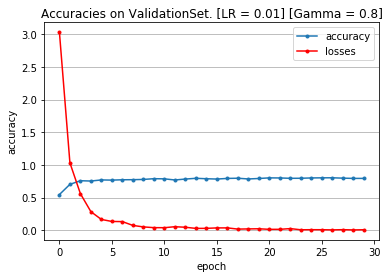


Best Accuracy on Validation set for epoch = 27 is: 0.8029045643153527, with loss = 0.0012445300817489624 and LR = 0.01


In [11]:
# By default, everything is loaded to cpu
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda

cudnn.benchmark # Calling this optimizes runtime

current_step = 0
max_accuracy = 0
val_accuracies = []
losses = []
sum_train_losses = 0
# Start iterating over the epochs
for epoch in range(NUM_EPOCHS):
  sum_train_losses = 0
  print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_lr()))


  # Iterate over the dataset
  for images, labels in train_dataloader:
    #set_trace()
    # Bring data over the device of choice
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    net.train() # Sets module in training mode

    # PyTorch, by default, accumulates gradients after each backward pass
    # We need to manually set the gradients to zero before starting a new iteration
    optimizer.zero_grad() # Zero-ing the gradients

    # Forward pass to the network
    outputs = net(images)

    # Compute loss based on output and ground truth
    loss = criterion(outputs, labels)

    # Log loss
    if current_step % LOG_FREQUENCY == 0:
      print('Step {}, Loss {}'.format(current_step, loss.item()))
    sum_train_losses += loss.item()*images.size(0)

    # Compute gradients for each layer and update weights
    loss.backward()  # backward pass: computes gradients
    optimizer.step() # update weights based on accumulated gradients

    current_step += 1

  #Evaluation on Validation set for each run
  net.train(False) # Set Network to evaluation mode

  running_corrects = 0
  for images, labels in tqdm(val_dataloader):
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    # Forward Pass
    outputs = net(images)

    # Get predictions
    _, preds = torch.max(outputs.data, 1)

    # Update Corrects
    running_corrects += torch.sum(preds == labels.data).data.item()

  # Calculate Accuracy
  accuracy = running_corrects / float(len(val_dataset_new))
  val_accuracies.append(accuracy)
  losses.append(sum_train_losses/float(len(train_dataset_new)))

  if(accuracy > max_accuracy):
    max_accuracy = accuracy
    best_epoch = epoch
    loss_best_epoch = loss.item()

  print('\nValidation Accuracy: {}'.format(accuracy))
  

  # Step the scheduler
  scheduler.step() 


plt.show()
plt.figure()
plt.plot(val_accuracies, marker=".", label="accuracy")
plt.plot(losses, "r", marker=".", label="losses")
plt.legend(loc="upper right")
plt.title("Accuracies on ValidationSet. [LR = {}] [Gamma = {}]".format(LR, GAMMA))
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.grid(axis='y')
plt.show()

print('\nBest Accuracy on Validation set for epoch = {} is: {}, with loss = {} and LR = {}'.format(best_epoch+1, max_accuracy, loss_best_epoch, LR))

**Test**

In [12]:
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
net.train(False) # Set Network to evaluation mode

running_corrects = 0
for images, labels in tqdm(test_dataloader):
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)

  # Forward Pass
  outputs = net(images)

  # Get predictions
  _, preds = torch.max(outputs.data, 1)

  # Update Corrects
  running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy
accuracy = running_corrects / float(len(test_dataset))

print('Test Accuracy: {}'.format(accuracy))

100%|██████████| 12/12 [00:08<00:00,  1.49it/s]

Test Accuracy: 0.8434151399930868
